In [1]:
from __future__ import print_function, division
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
%pylab notebook
import os
import sys
import numpy as np
import random
import copy
import traceback
import operator
from collections import defaultdict
from pprint import pprint
import string
from graph_tool.all import *
import scipy.stats as stats
from IPython.display import HTML
import powerlaw
import pandas as pd
import sys
import os
lib_path = '/home/fgeigl/'
print('append', lib_path)
sys.path.append(lib_path)
import tools.mpl_tools as plt_tools
# import seaborn
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rcParams['xtick.major.pad'] *= 2
matplotlib.rcParams['ytick.major.pad'] *= 2

Populating the interactive namespace from numpy and matplotlib
append /home/fgeigl/


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def find_files(base_dir, file_ending):
    res = list()
    for root, dirs, files in os.walk(base_dir):
        if not root.endswith('/'):
            root += '/'
        res.extend([root + i for i in filter(lambda x: x.endswith(file_ending), files)])
    return sorted(res)

base_dir = '/home/fgeigl/navigability_of_networks/output/opt_link_man/'
df_files = filter(lambda x: 'preprocessed' in x, find_files(base_dir,'.df'))
debug = False
plots_dir = base_dir + '/plots/'
if not os.path.isdir(plots_dir):
    os.makedirs(plots_dir)


data_sets = defaultdict(set)
for f in df_files:
    dset = f.rsplit('/',1)[-1].split('.gt',1)[0]
    data_sets[dset].add(f)

for key, val in data_sets.iteritems():
    print(key)
    for i in sorted(val):
        print('\t',i)

daserste
	 /home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt_bs0002_preprocessed.df
	 /home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt_bs0003_preprocessed.df
	 /home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt_bs0005_preprocessed.df
	 /home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt_bs0010_preprocessed.df
	 /home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt_bs0015_preprocessed.df
	 /home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt_bs0030_preprocessed.df
	 /home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt_bs0060_preprocessed.df
	 /home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt_bs0100_preprocessed.df
	 /home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt_bs0150_preprocessed.df
	 /home/fgeigl/navigability_

In [3]:
max_sample_size = 0.21
data_dict = dict()
for key, val in sorted(data_sets.iteritems(), key=operator.itemgetter(0), reverse=True)[:(1 if debug else len(data_sets))]:
    df_all = None
    print('read all dfs for', key, end=' ')
    sys.stdout.flush()
    for df_file in sorted(val):
        print('.', end='')
        bs = int(df_file.rsplit('_bs',1)[-1].split('_',1)[0])
        if bs > 200:
            continue
        df = pd.read_pickle(df_file)
        # print(sorted(df.columns))
        df = df[['sample-size', 'stat_dist_com_sum', 'orig_stat_dist_sum', 'add_top_block_links_fair']]        
        df['sample-size'] = np.round(df['sample-size'], 3)
        df = df[map(lambda x: x < max_sample_size ,df['sample-size'])]
        df['bias-strength'] = bs
        if df_all is None:
            df_all = df.copy()
        else:
            df_all = pd.concat([df_all, df])
    # print(df_all.head())
    data_dict[key] = df_all.copy()
    print('\nsample-sizes', sorted(set(df_all['sample-size'])))
    print('bias-strengths', sorted(set(df_all['bias-strength'])))

read all dfs for wiki4schools ..........
sample-sizes [0.01, 0.025000000000000001, 0.050000000000000003, 0.074999999999999997, 0.10000000000000001, 0.125, 0.14999999999999999, 0.17499999999999999, 0.20000000000000001]
bias-strengths [2, 3, 5, 10, 15, 30, 60, 100, 150, 200]
read all dfs for tvthek_orf ..........
sample-sizes [0.01, 0.025000000000000001, 0.050000000000000003, 0.074999999999999997, 0.10000000000000001, 0.125, 0.14999999999999999, 0.17499999999999999, 0.20000000000000001]
bias-strengths [2, 3, 5, 10, 15, 30, 60, 100, 150, 200]
read all dfs for daserste ..........
sample-sizes [0.01, 0.025000000000000001, 0.050000000000000003, 0.074999999999999997, 0.10000000000000001, 0.125, 0.14999999999999999, 0.17499999999999999, 0.20000000000000001]
bias-strengths [2, 3, 5, 10, 15, 30, 60, 100, 150, 200]


<IPython.core.display.Javascript object>


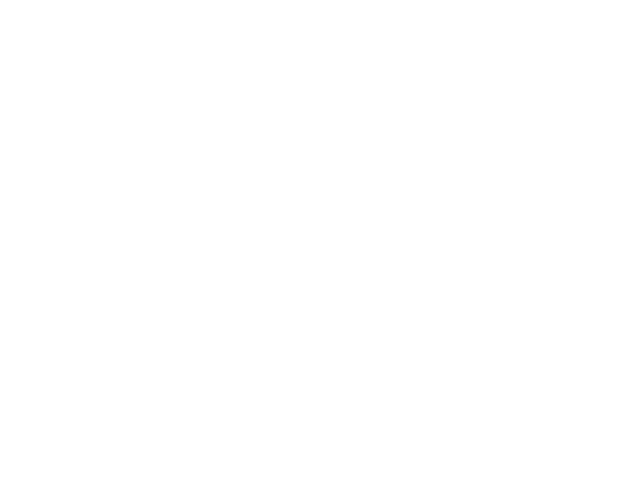

Method: link_inseration


<IPython.core.display.Javascript object>


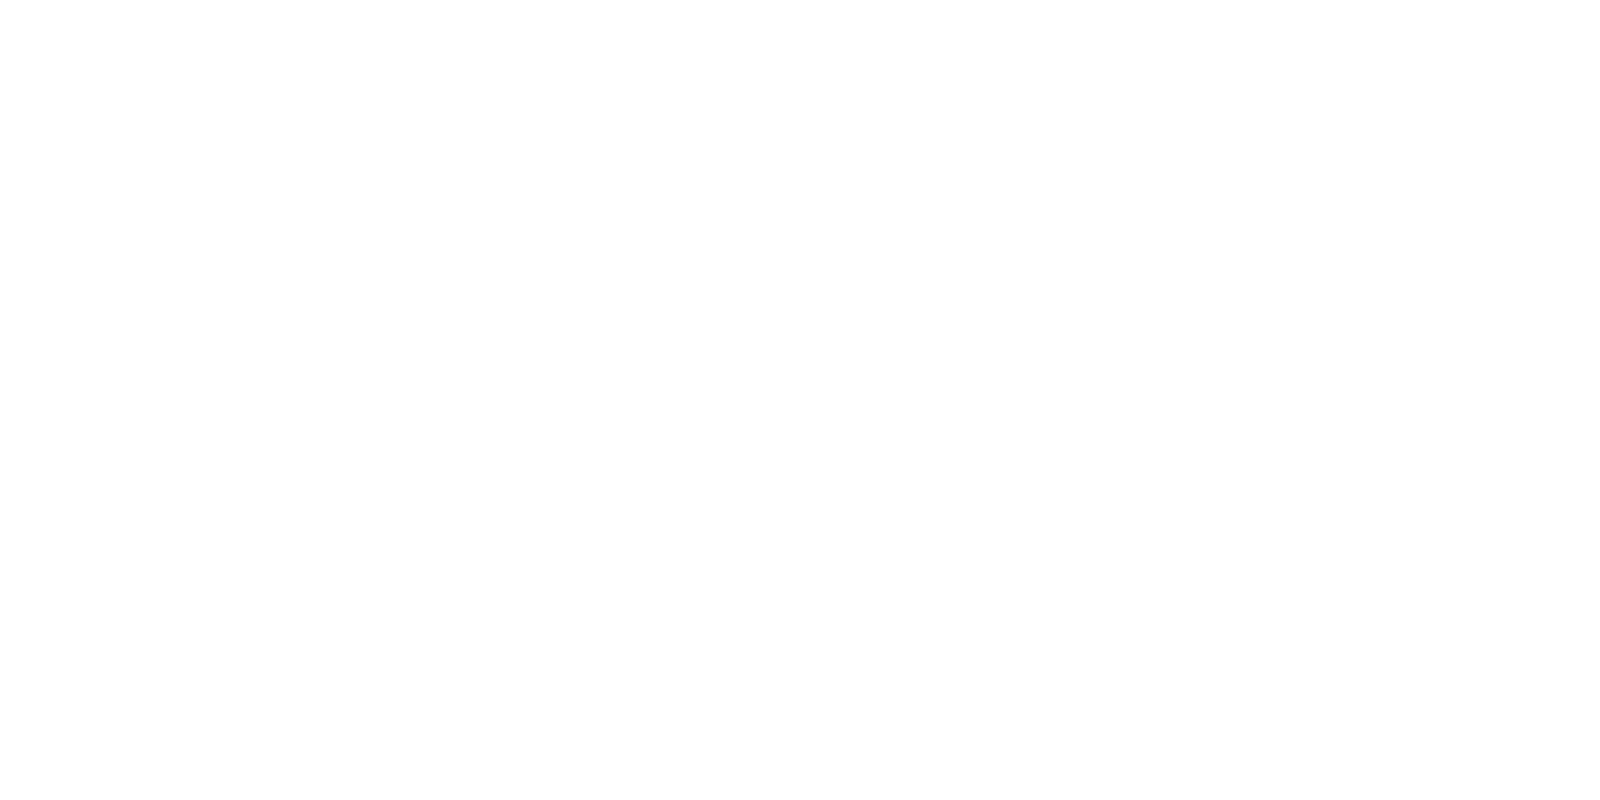

<IPython.core.display.Javascript object>


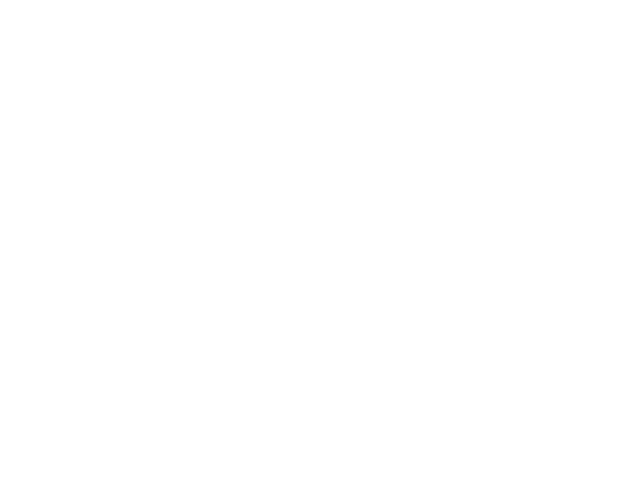

Method: bias


<IPython.core.display.Javascript object>


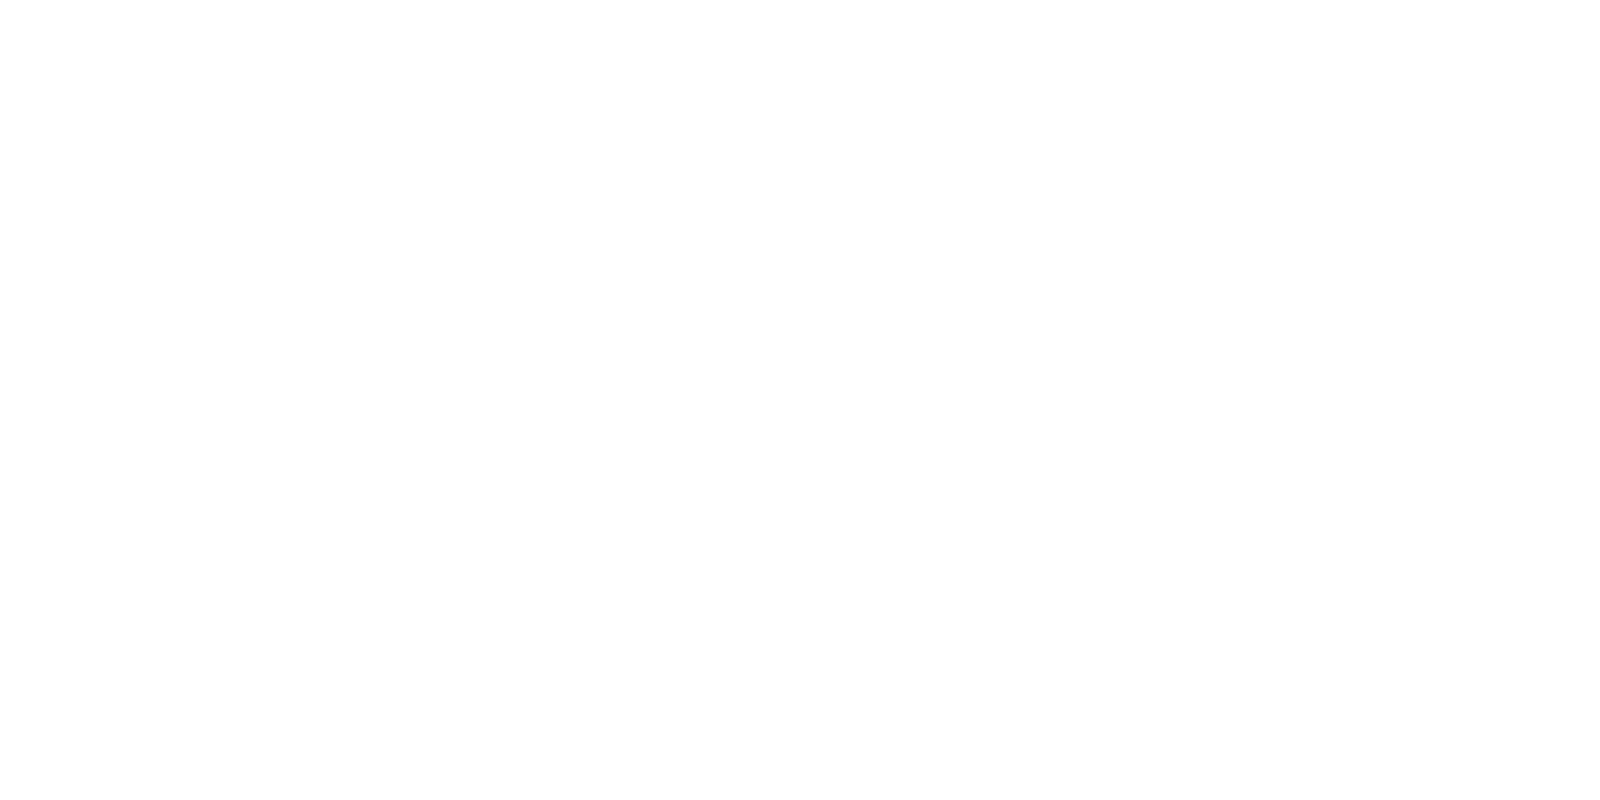

In [4]:
sample_sizes = [0.01, 0.1, 0.2]
ds_names_conv = {'wiki4schools':'W4S', 'tvthek_orf':'ORF', 'daserste':'DEM'}
import matplotlib.patches as patches

colors = ['#e41a1c','#377eb8','#4daf4a']
markers = "ov^<>sp*+x"
line_styles = ['--', '-', ':']
matplotlib.rcParams.update({'font.size': 25})
# matplotlib.rcParams.update({'mathtext.fontset' : 'custom'})
#matplotlib.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
for method in ['link_inseration', 'bias']:
    fig, ax = plt.subplots()
    ax.plot([],[],alpha=0.,label=r'dataset')
    print('Method:', method)
    measure = 'add_top_block_links_fair' if method == 'link_inseration' else 'stat_dist_com_sum'
    for idx, (ds_name, val) in enumerate(sorted(data_dict.iteritems(), key=operator.itemgetter(0), reverse=True)):
        # fig, ax = plt.subplots()
        c = colors[idx]
        for jdx, (key, df) in enumerate(val[map(lambda x: x in sample_sizes ,val['sample-size'])].groupby('sample-size')):
            filt_df = df[['bias-strength', measure]]
            grp_df = filt_df.groupby('bias-strength')
            grp_mean = grp_df.mean()
            grp_x = np.array(grp_mean.index)
            grp_mean = np.array(grp_mean).flatten()
            grp_std = np.array(grp_df.std()).flatten()
            #print(len(grp_x), len(grp_mean), len(grp_std))
            #print(grp_x)
            #print(grp_mean)
            #print(grp_std)
            ax.plot(grp_x, grp_mean, lw=3, color=c, label=ds_names_conv[ds_name] if jdx == 1 else None, 
                    marker=markers[idx], ms=12, ls=line_styles[jdx], markeredgewidth = 2, markeredgecolor = (.99, .99, .99, .9))
            # ax.fill_between(grp_x, grp_mean - grp_std, grp_mean + grp_std, alpha=0.2, color=c,)
            # plt.show()
    split_at = 30
    start_at = 2
    patch_alpha = 0.1
    
    ax.add_patch(
        patches.Rectangle(
            (start_at, 0.),   # (x,y)
            split_at - start_at,          # width
            1.,          # height
            color='blue', alpha=patch_alpha
        )
    )
    
    ax.add_patch(
        patches.Rectangle(
            (split_at, 0.),   # (x,y)
            200-split_at,          # width
            1.,          # height
            color='red', alpha=patch_alpha
        )
    )
    
    ax.set_xlabel('bias strength ($b$)')
    ax.set_ylabel("energy ($\pi'_t$)")
    ax.grid(b=True, which='major', axis='y', linewidth=3, alpha=0.2, ls='--')
    # ax.legend(loc='best')
    ax.set_ylim([0,1])
    plt.tight_layout()
    plt.show()
    plt_tools.save_n_crop(plots_dir + 'saturation_' + method + '.pdf')
    ax.plot([],[],alpha=0.,label=r'fraction of target nodes ($\phi$)')
    ax.plot([],[],alpha=1.,c='black', label=r'$0.01$', ls='--', lw=3)
    ax.plot([],[],alpha=1.,c='black',label=r'$0.1$', ls='-', lw=3)
    ax.plot([],[],alpha=1.,c='black',label=r'$0.2$', ls=':', lw=3)
    plt_tools.plot_legend(ax, plots_dir + 'saturation_legend.pdf', close_plot=False, ncols=4, legend_name_idx=[0, 4], legend_name_style='it')

In [5]:
def get_net_dict():
    net_files = filter(lambda x: 'bow_tie' not in x, find_files(base_dir,'.gt'))
    print('Networks:', net_files)
    networks = dict()
    ds_name_conv = {'daserste.gt':'DEM', 'tvthek_orf.gt':'ORF', 'wiki4schools.gt':'W4S'}
    for i in net_files:
        print('\tload:', i.rsplit('/', 1)[-1])
        networks[ds_name_conv[i.rsplit('/',1)[-1]]] = load_graph(i)
    print(networks)
    return networks
networks_dict = get_net_dict()
print(ds_names_conv)

Networks: ['/home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt', '/home/fgeigl/navigability_of_networks/output/opt_link_man/tvthek_orf.gt/tvthek_orf.gt', '/home/fgeigl/navigability_of_networks/output/opt_link_man/wiki4schools.gt/wiki4schools.gt']
	load: daserste.gt
	load: tvthek_orf.gt
	load: wiki4schools.gt
{'ORF': <Graph object, directed, with 9799 vertices and 301844 edges at 0x7f2115120ed0>, 'W4S': <Graph object, directed, with 4051 vertices and 111795 edges at 0x7f21150a9d90>, 'DEM': <Graph object, directed, with 70063 vertices and 3448513 edges at 0x7f214d85dfd0>}
{'daserste': 'DEM', 'tvthek_orf': 'ORF', 'wiki4schools': 'W4S'}


Method: link_inseration


<IPython.core.display.Javascript object>


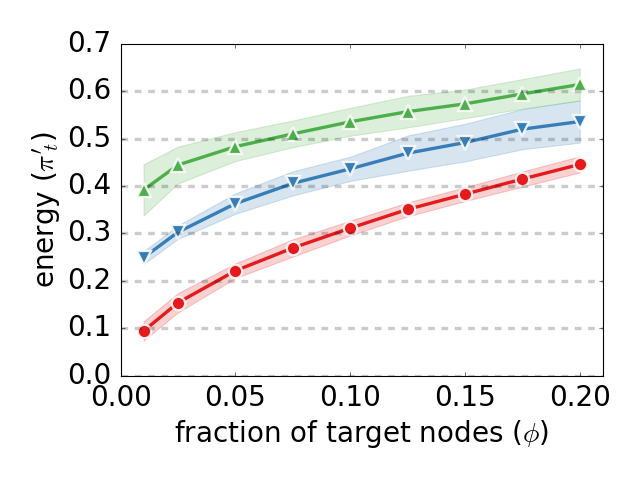

W4S std mean: 0.0169110685498
ORF std mean: 0.0293775578539
DEM std mean: 0.0344339251775


<IPython.core.display.Javascript object>

Method: bias


<IPython.core.display.Javascript object>

W4S std mean: 0.0234246364243
ORF std mean: 0.102902642417
trigger
sample idx: 455
0.1 0.558715784231
sample idx: 822
0.2 0.283109711439
DEM std mean: 0.0684569006443


<IPython.core.display.Javascript object>

In [6]:

net_perf_dict = dict()
plt.close('all')
matplotlib.rcParams.update({'font.size': 25})
bias_strength = 5
max_sample_phi = 0.1
min_sample_phi = 0.2
min_sample_idx = None
max_sample_idx = None
sample_ds = 'ORF'
for m_idx, method in enumerate(['link_inseration', 'bias']):
    print('Method:', method)
    measure = 'add_top_block_links_fair' if method == 'link_inseration' else 'stat_dist_com_sum'
    fig, ax = plt.subplots()
    ax.plot([np.nan],[np.nan], label='dataset', lw=0, color='white', alpha=0., linestyle=':')
    for idx, (key, val) in enumerate(sorted(data_dict.iteritems(), key=operator.itemgetter(0), reverse=True)):
        # fig, ax = plt.subplots()
        ds_name = ds_names_conv[key]
        df = val[val['bias-strength'] == bias_strength].copy()
        df.drop('bias-strength', axis=1, inplace=True)
        # print(df.columns)
        df = df[['sample-size', measure]]
        grp_df = df.groupby('sample-size')
        grp_mean = grp_df.mean()
        if m_idx == 0:
            net_perf_dict[ds_name] = grp_df
        grp_std = grp_df.std()
        grp_x = np.array(grp_mean.index)
        grp_mean = np.array(grp_mean).flatten()
        grp_std = np.array(grp_df.std()).flatten()
        # print(len(grp_x), len(grp_mean), len(grp_std))
        # print(grp_x)
        # print(grp_mean)
        # print(grp_std)
        print(ds_name, 'std mean:', grp_std.mean())
        ax.plot(grp_x, grp_mean, lw=3, color=colors[idx], label=ds_name, marker=markers[idx], 
                ms=12, ls=line_styles[1], markeredgewidth = 2, markeredgecolor = (.99, .99, .99, .9))
        ax.fill_between(grp_x, grp_mean - grp_std, grp_mean + grp_std, alpha=0.2, color=colors[idx], label=None)
            # plt.show()
        if m_idx == 1 and sample_ds == ds_name:
            print('trigger')
            line_data = list()
            for key, key_df in grp_df:
                min_max_close = np.isclose([key, key], [min_sample_phi, max_sample_phi])
                if any(min_max_close):
                    sample_type = 'min' if min_max_close[0] else 'max'
                    select_f = np.argmin if sample_type == 'min' else np.argmax
                    sample_idx = select_f(key_df[measure])
                    print('sample idx:', sample_idx)
                    if sample_type == 'min':
                        min_sample_idx = sample_idx
                    else:
                        max_sample_idx = sample_idx
                    sample_dp = key_df.loc[sample_idx]
                    x = key
                    y = sample_dp[measure]
                    print(x,y)
                    line_data.append((x, y))
                    ax.plot(x, y, marker='o', ms=14, color='none', markeredgecolor=colors[idx], markeredgewidth=2)
                    text_offset = 0.05
                    ax.text(key, y + text_offset, 'A' if sample_type == 'max' else 'B', 
                            horizontalalignment='center',
                            verticalalignment='center',
                            )
                    ax.text(key - 0.012, y - text_offset, "$\pi'_t=$%.2f" % np.round(y, decimals=2), 
                            horizontalalignment='center',
                            verticalalignment='center',
                            fontsize=15
                            )
            if m_idx == 1:
                ax.plot(*zip(*line_data), color=colors[idx], lw=2, alpha=0.9, ls='--', zorder=100) 
    ax.set_xlabel(r'fraction of target nodes ($\phi$)')
    ax.set_ylabel("energy ($\pi'_t$)")
    ax.set_ylim([0,.7])
    ax.set_xlim([0,0.21])
    ax.grid(b=True, which='major', axis='y', linewidth=3, alpha=0.2, ls='--')
    
        
        #ax.annotate('A',
        #    xy=(0.1, 0.41),  # theta, radius
        #    xytext=(0.075, 0.45),    # fraction, fraction
        #    arrowprops=dict(facecolor='black', shrink=0.05),
        #    horizontalalignment='right',
        #    verticalalignment='center',
        #    )
        #ax.annotate('B',
        #    xy=(0.2, 0.39),  # theta, radius
        #    xytext=(0.2, 0.3),    # fraction, fraction
        #    arrowprops=dict(facecolor='black', shrink=0.05),
        #    horizontalalignment='center',
        #    verticalalignment='top',
        #    )
        #ax.plot([0.1, 0.2],[0.41, 0.39], color='black', lw=2, alpha=.75, ls='--')
    plt.tight_layout()
    plt.show()
    plt_tools.save_n_crop(plots_dir + 'stat_dist_abs_'+ method + '_bs' + str("%.0f" % bias_strength).rjust(4, '0') + '.pdf')
    plt_tools.plot_legend(ax, plots_dir + 'stat_dist_abs_'+ method + '_legend.pdf', close_plot=False, legend_name_idx=0, legend_name_style='it')

In [7]:
data = list()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
for key, val in net_perf_dict.iteritems():
    net = networks_dict[key]
    net_property = net.num_edges()/(net.num_vertices()*(net.num_vertices()-1))
    for phi, gdf in val:       
        data.extend([(net_property, phi, i) for i in gdf['add_top_block_links_fair']])
corr_df = pd.DataFrame(columns=['property', 'phi', 'performance'], data=data)
print(corr_df.head())
print('------')
for key, df in corr_df.groupby(by='phi'):
    print('phi', key)
    print(df.corr())

   property   phi  performance
0     0.003 0.010        0.241
1     0.003 0.010        0.258
2     0.003 0.010        0.253
3     0.003 0.010        0.249
4     0.003 0.010        0.243
------
phi 0.01
             property    phi  performance
property        1.000 -0.000       -0.959
phi            -0.000  1.000        0.000
performance    -0.959  0.000        1.000
phi 0.025
             property   phi  performance
property        1.000 0.000       -0.971
phi             0.000 1.000        0.000
performance    -0.971 0.000        1.000
phi 0.05
             property    phi  performance
property        1.000  0.000       -0.975
phi             0.000  1.000       -0.000
performance    -0.975 -0.000        1.000
phi 0.075
             property    phi  performance
property        1.000 -0.000       -0.970
phi            -0.000  1.000       -0.000
performance    -0.970 -0.000        1.000
phi 0.1
             property    phi  performance
property        1.000  0.000       -0.966
phi      

In [8]:
for m_idx, method in enumerate(['link_inseration', 'bias']):
    print('Method:', method)
    measure = 'add_top_block_links_fair' if method == 'link_inseration' else 'stat_dist_com_sum'
    fig, ax = plt.subplots()
    ax.plot([np.nan],[np.nan], label='dataset', lw=0, color='white', alpha=0., linestyle=':')
    for idx, (key, val) in enumerate(sorted(data_dict.iteritems(), key=operator.itemgetter(0), reverse=True)):
        # fig, ax = plt.subplots()
        ds_name = ds_names_conv[key]
        df = val[val['bias-strength'] == bias_strength].copy()
        df.drop('bias-strength', axis=1, inplace=True)
        # print(df.columns)
        df = df[['sample-size', measure, 'orig_stat_dist_sum']]
        df['relative_stat'] = df[measure] / df['orig_stat_dist_sum']
        df.drop([measure, 'orig_stat_dist_sum'], axis=1, inplace=True)
        grp_df = df.groupby('sample-size')
        grp_mean = grp_df.mean()
        grp_std = grp_df.std()
        grp_x = np.array(grp_mean.index)
        grp_mean = np.array(grp_mean).flatten()
        grp_std = np.array(grp_df.std()).flatten()
        # print(len(grp_x), len(grp_mean), len(grp_std))
        # print(grp_x)
        # print(grp_mean)
        # print(grp_std)
        print(ds_name, 'std mean:', grp_std.mean())
        ax.plot(grp_x, grp_mean, lw=3, color=colors[idx], label=ds_name, marker=markers[idx], ms=12, ls=line_styles[1], markeredgewidth = 2, markeredgecolor = (.99, .99, .99, .9))
        ax.fill_between(grp_x, grp_mean - grp_std, grp_mean + grp_std, alpha=0.2, interpolate=True, color=colors[idx])
        if m_idx == 1 and sample_ds == ds_name:
            print('trigger')
            line_data = list()
            for key, key_df in grp_df:
                min_max_close = np.isclose([key, key], [min_sample_phi, max_sample_phi])
                if any(min_max_close):
                    sample_type = 'min' if min_max_close[0] else 'max'
                    sample_idx = min_sample_idx if sample_type == 'min' else max_sample_idx
                    sample_dp = key_df.loc[sample_idx]
                    x = key
                    y = sample_dp['relative_stat']
                    print(x,y)
                    line_data.append((x, y))
                    ax.plot(x, y, marker='o', ms=14, color='none', markeredgecolor=colors[idx], markeredgewidth=2)
                    text_offset = np.power(10, 0.05)
                    if sample_type == 'max':
                        ax.text(key - 0.012, y, 'A', 
                                horizontalalignment='center',
                                verticalalignment='center',
                                )
                    else:
                        ax.text(key, y + text_offset, 'B', 
                                horizontalalignment='center',
                                verticalalignment='center',
                                )
                    #ax.text(key - 0.012, y - text_offset, "$\tau=$%.2f" % np.round(y, decimals=2), 
                    #        horizontalalignment='center',
                    #        verticalalignment='center',
                    #        fontsize=15
                    #        )
            if m_idx == 1:
                ax.plot(*zip(*line_data), color=colors[idx], lw=2, alpha=0.9, ls='--', zorder=100) 
            
        
    ax.set_xlabel(r'fraction of target nodes ($\phi$)')
    ax.set_ylabel(r'influence potential ($\tau$)')
    # ax.set_ylim([0,.55])
    ax.grid(b=True, which='major', axis='y', linewidth=3, alpha=0.2, ls='--')
    ax.set_ylim([2., 200])
    ax.set_xlim([0.,0.21])
    ax.set_yscale('log')
    plt.tight_layout()
    plt.show()
    plt_tools.save_n_crop(plots_dir + 'stat_dist_rel_'+ method +  '_bs' + str("%.0f" % bias_strength).rjust(4, '0') + '.pdf')
    plt_tools.plot_legend(ax,plots_dir + 'stat_dist_rel_'+ method + '_legend.pdf', close_plot=False, legend_name_idx=0, legend_name_style='it')

Method: link_inseration


<IPython.core.display.Javascript object>

W4S std mean: 0.348416525488
ORF std mean: 7.75007441626
DEM std mean: 14.6409800981


<IPython.core.display.Javascript object>

Method: bias


<IPython.core.display.Javascript object>

W4S std mean: 0.0903068813545
ORF std mean: 0.407569893159
trigger
0.1 2.34959008617
0.2 3.24064072469
DEM std mean: 0.340670789015


<IPython.core.display.Javascript object>

In [9]:
exit()